### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer

### Brief Exploration

In [2]:
#defining directory paths
image_dir = '/kaggle/input/analog-clocks/analog_clocks/images/'
labels_dir = '/kaggle/input/analog-clocks/analog_clocks/label.csv'

In [3]:
#examining labels
labels = pd.read_csv(labels_dir)
labels.describe()

,hour,minute
count,50000.000000,50000.000000
mean,5.522940,29.531240
std,3.459953,17.210759
min,0.000000,0.000000
25%,3.000000,15.000000
50%,6.000000,30.000000
75%,9.000000,44.000000
max,11.000000,59.000000


In [4]:
#distribution of classes in hour column
labels.hour.value_counts(normalize=True)

8     0.08580
11    0.08546
6     0.08462
10    0.08452
1     0.08428
2     0.08290
7     0.08286
3     0.08248
0     0.08246
4     0.08180
5     0.08164
9     0.08118
Name: hour, dtype: float64

In [5]:
#distribution of classes in minute column
labels.minute.value_counts(normalize=True)

37    0.01804
19    0.01790
39    0.01778
32    0.01776
44    0.01774
45    0.01744
13    0.01744
28    0.01736
17    0.01734
47    0.01732
4     0.01724
21    0.01718
22    0.01716
26    0.01710
16    0.01708
46    0.01706
34    0.01704
36    0.01702
23    0.01700
55    0.01692
50    0.01690
49    0.01688
27    0.01686
51    0.01684
33    0.01682
11    0.01680
7     0.01680
31    0.01674
42    0.01672
38    0.01670
41    0.01670
24    0.01662
15    0.01652
18    0.01652
48    0.01650
57    0.01646
12    0.01644
6     0.01644
20    0.01642
8     0.01642
1     0.01640
56    0.01632
59    0.01630
3     0.01630
29    0.01628
0     0.01626
9     0.01624
52    0.01614
40    0.01610
53    0.01602
54    0.01600
10    0.01598
35    0.01586
14    0.01580
5     0.01576
25    0.01574
30    0.01574
2     0.01566
58    0.01556
43    0.01552
Name: minute, dtype: float64

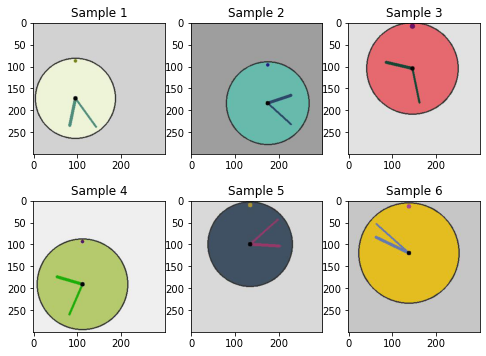

In [6]:
#preview of dataset
sample_dir = '/kaggle/input/analog-clocks/analog_clocks/samples/'
fig = plt.figure(figsize=(8, 6))
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

### Data Processing

In [7]:
#transforming labels to multi-label binary format
labels = pd.read_csv(labels_dir).values
labels = [tuple(x) for x in labels]
labels = [('h' + str(x), 'm' + str(y)) for x,y in labels]    #'h' and 'm' are added to hours and minutes respectively to distinguish them
binarizer = MultiLabelBinarizer()
labels = binarizer.fit_transform(labels)

In [8]:
def generate(image_directory, labels, batch_size=64, size=(224, 224)):
    
    """
    Function to create generator of images and labels for the neural network. This allows for training
    the model with the limited memory available. The images and labels are generated in batches of a given size.
    The images are loaded, added to a batch, preprocessed and have their features extracted using a prebuilt model
    (in this case Xception Model). 
    
    Parameters
    ----------
    image_directory: str
        The path where the images are located
    labels: array-like or list
        list of labels in multi-label binary format
    batch_size: int, default=64
        the number of images per batch
    size: tuple, default=(224, 224)
        the height and width to which the image is resized. 
    
    Yields
    ------
    image_batch: array
        Array of image features of size=batch_size
    labels_batch: array
        Array of labels in multi-label binary format of size=batch_size
    
    """
    
   
    prebuilt_model = xception.Xception(include_top=True,                      
              weights='imagenet')                                            #loading prebuilt model
    
    xception_model = Model(inputs=prebuilt_model.input,        
                      outputs=prebuilt_model.layers[-2].output)              #repurposing prebuilt model for feature extraction
    
    while 1:
        
        image_filenames = os.listdir(image_directory)                        #obtaining list of image filenames
        random.shuffle(image_filenames)                                      #shuffling the list to add randomness every epoch

        
        image_batch = []                                                     #initializing empty image batch list
        labels_batch = []                                                    #initializing empty labels batch list
        
        for file in image_filenames:                                         #looping over all images in directory

            index = int(file.split('.')[0])                                  #extracting image number/index from filename
            
            img = image.load_img(os.path.join(image_directory, file),        #loading image
                                 target_size=size,
                                 interpolation='box')
            
            img_arr = image.img_to_array(img, dtype='float32')               #converting image to array
            
            label = labels[index]                                            #using image number/index to find correct label in dataframe
    
            image_batch.append(img_arr)                                      #appending the image to the batch
            labels_batch.append(label)                                       #appending the label to the batch

    
            if len(image_batch)==batch_size:                                 #check to see if batch has required size
                image_batch = np.array(image_batch)                          #converting image batch list to array
                image_batch = xception.preprocess_input(image_batch)         #using xception preprocessing on image batch array
                image_features = xception_model.predict(image_batch)         #using prebuilt xception model to extract features from batch
                image_batch = np.array(image_features)                       #converting features to array
                image_batch = image_batch.reshape(batch_size,                #reshaping feature array
                                                  image_features.shape[1])   
                labels_batch = np.array(labels_batch)                        #converting labels batch list to array
                yield image_batch, labels_batch                              #yielding image and labels batch array
                image_batch = []                                             #reinitializing the image batch
                labels_batch = []                                            #reinitializing the label batch
                gc.collect()                                                 #collecting garbage to free memory


In [9]:
#Defining training parameters
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(labels.shape[0] / BATCH_SIZE)

In [10]:
#testing generator
sample_generator = next(generate(image_directory=image_dir, 
                                 labels=labels, 
                                 batch_size=1, 
                                 size=IMAGE_SIZE))

91889664/91884032 [==============================] - 1s 0us/step


In [11]:
#output of generator
sample_generator

(array([[0.        , 0.        , 0.00143245, ..., 0.03733912, 0.20625672,
         0.28545055]], dtype=float32),
 array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

In [12]:
#extracting input and output dims from generator
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [13]:
print(INPUT_DIM, OUTPUT_DIM)

(2048,) 72


In [14]:
def create_model(input_shape, output_shape):
    
    """
    Function to build and compile neural network to predict analog clocks from images
    
    Parameters
    ----------
    input_shape: tuple
        Shape tuple not including the batch_size, example: (2048, )
    output_shape: int
        Number of nodes in final layer
    
    Returns
    -------
    model: Keras model object
        A compiled Keras model
    """

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)
    
    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)
    
    #compiling model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    
    return model

In [15]:
#creating instance of model
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 72)                18504     
Total params: 617,032
Trainable params: 612,936
Non-trainable params: 4,096
_________________________________________________________________


In [17]:
#initializing generator for training
generator = generate(image_directory=image_dir,
                     labels=labels, 
                     batch_size=BATCH_SIZE, 
                     size=IMAGE_SIZE)

In [18]:
#fitting model
history = model.fit(generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS)

Epoch 1/10
195/195 [==============================] - 570s 3s/step - loss: 0.1104 - accuracy: 0.4480
Epoch 2/10
195/195 [==============================] - 514s 3s/step - loss: 0.0645 - accuracy: 0.6892
Epoch 3/10
195/195 [==============================] - 517s 3s/step - loss: 0.0531 - accuracy: 0.7599
Epoch 4/10
195/195 [==============================] - 518s 3s/step - loss: 0.0463 - accuracy: 0.8011
Epoch 5/10
195/195 [==============================] - 517s 3s/step - loss: 0.0412 - accuracy: 0.8290
Epoch 6/10
195/195 [==============================] - 514s 3s/step - loss: 0.0373 - accuracy: 0.8523
Epoch 7/10
195/195 [==============================] - 517s 3s/step - loss: 0.0341 - accuracy: 0.8646
Epoch 8/10
195/195 [==============================] - 516s 3s/step - loss: 0.0313 - accuracy: 0.8803
Epoch 9/10
195/195 [==============================] - 509s 3s/step - loss: 0.0290 - accuracy: 0.8861
Epoch 10/10
195/195 [==============================] - 520s 3s/step - loss: 0.0270 - accura

### Model Prediction on Sample

In [19]:
def predict(path):
    
    """
    Function to predict all images in a given path
    
    Parameters
    ----------
    path: str
        Path for images to be predicted
    """
    
    
    prebuilt_model = xception.Xception(include_top=True,
              weights='imagenet')                              #loading pre-built model
    
    xception_model = Model(inputs=prebuilt_model.input,
                      outputs=prebuilt_model.layers[-2].output)#repurposing pre-built model for feature extraction
    
    fig = plt.figure(figsize=(8, 6))                           #creating figure to plot all images
    
    #looping over all images in path
    for i, file in enumerate(os.listdir(path)):
        

        img = image.load_img(os.path.join(path, file))         #loading images
        img_arr = image.img_to_array(img, dtype='float32')     #converting images to array
        
                
        plt.subplot(2, 3, i+1)                                 #creating subplot for image
        plt.imshow(img_arr/255.0)                              #plotting image
        
        img_arr = np.expand_dims(img_arr, axis=0)              #adding extra dim to image array
        img_arr = xception.preprocess_input(img_arr)           #preprocessing image array using xception method
        img_features = xception_model.predict(img_arr)         #extracting features from image using prebuilt xception model
        
        prediction = model.predict(img_features)[0]            #predicting time from image features                        
        
        hour_max = np.argmax(prediction[:12])                  #obtaining hour with the highest probability
        minute_max = np.argmax(prediction[12:]) + 12           #obtaining minute with the highest probability
        
        
        title = 'Prediction' + ': ' + binarizer.classes_[hour_max] + ' ' + binarizer.classes_[minute_max]
        plt.title(title)                                       #adding title to subplot

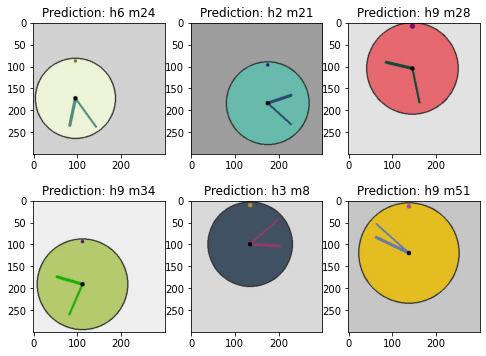

In [20]:
#predicting and plotting all images in sample directory
predict('/kaggle/input/analog-clocks/analog_clocks/samples/')

In [21]:
for layer in model.layers:
    layer.trainable = False

In [22]:
model.save('model')

### Take Aways

- Prebuilt models are very useful to extract features in this case
- Treating this problem as a multi-label classification achieves the best results over multi-class, possible due to lower dimensionality of labels (72 verus 720)
    - Initially tried having two outputs to the model, one for hours and one for minutes, but the model prioritizes optimizing hours over minutes
- It is difficult to obtain a reliable test set since there doesn't seem to be a way to stratify the different classes (have equal representation of each time in test set)
    - Since this is a generated dataset, it would be possible to produce another dataset for test purposes that has equal representation of each time